In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
40745,NaN,NaN,International,2020-08-29,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40746,NaN,NaN,International,2020-08-30,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40747,NaN,NaN,International,2020-08-31,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


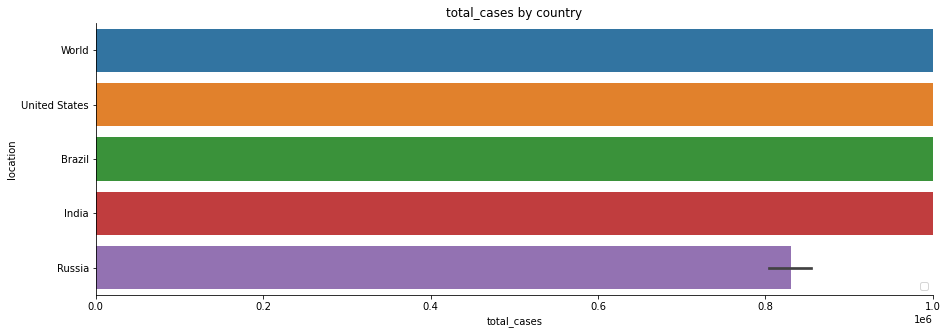

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


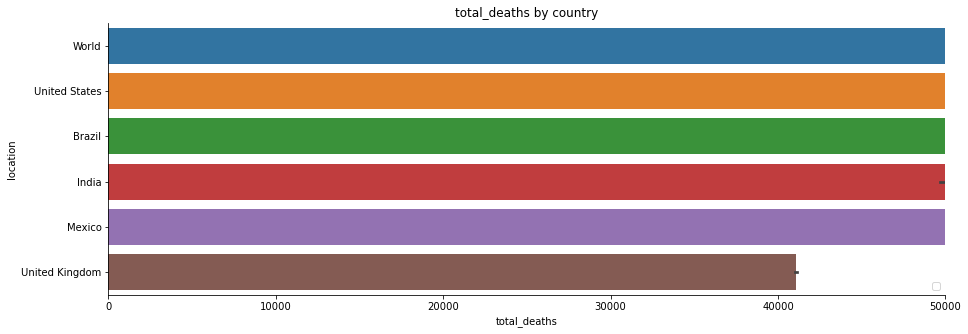

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


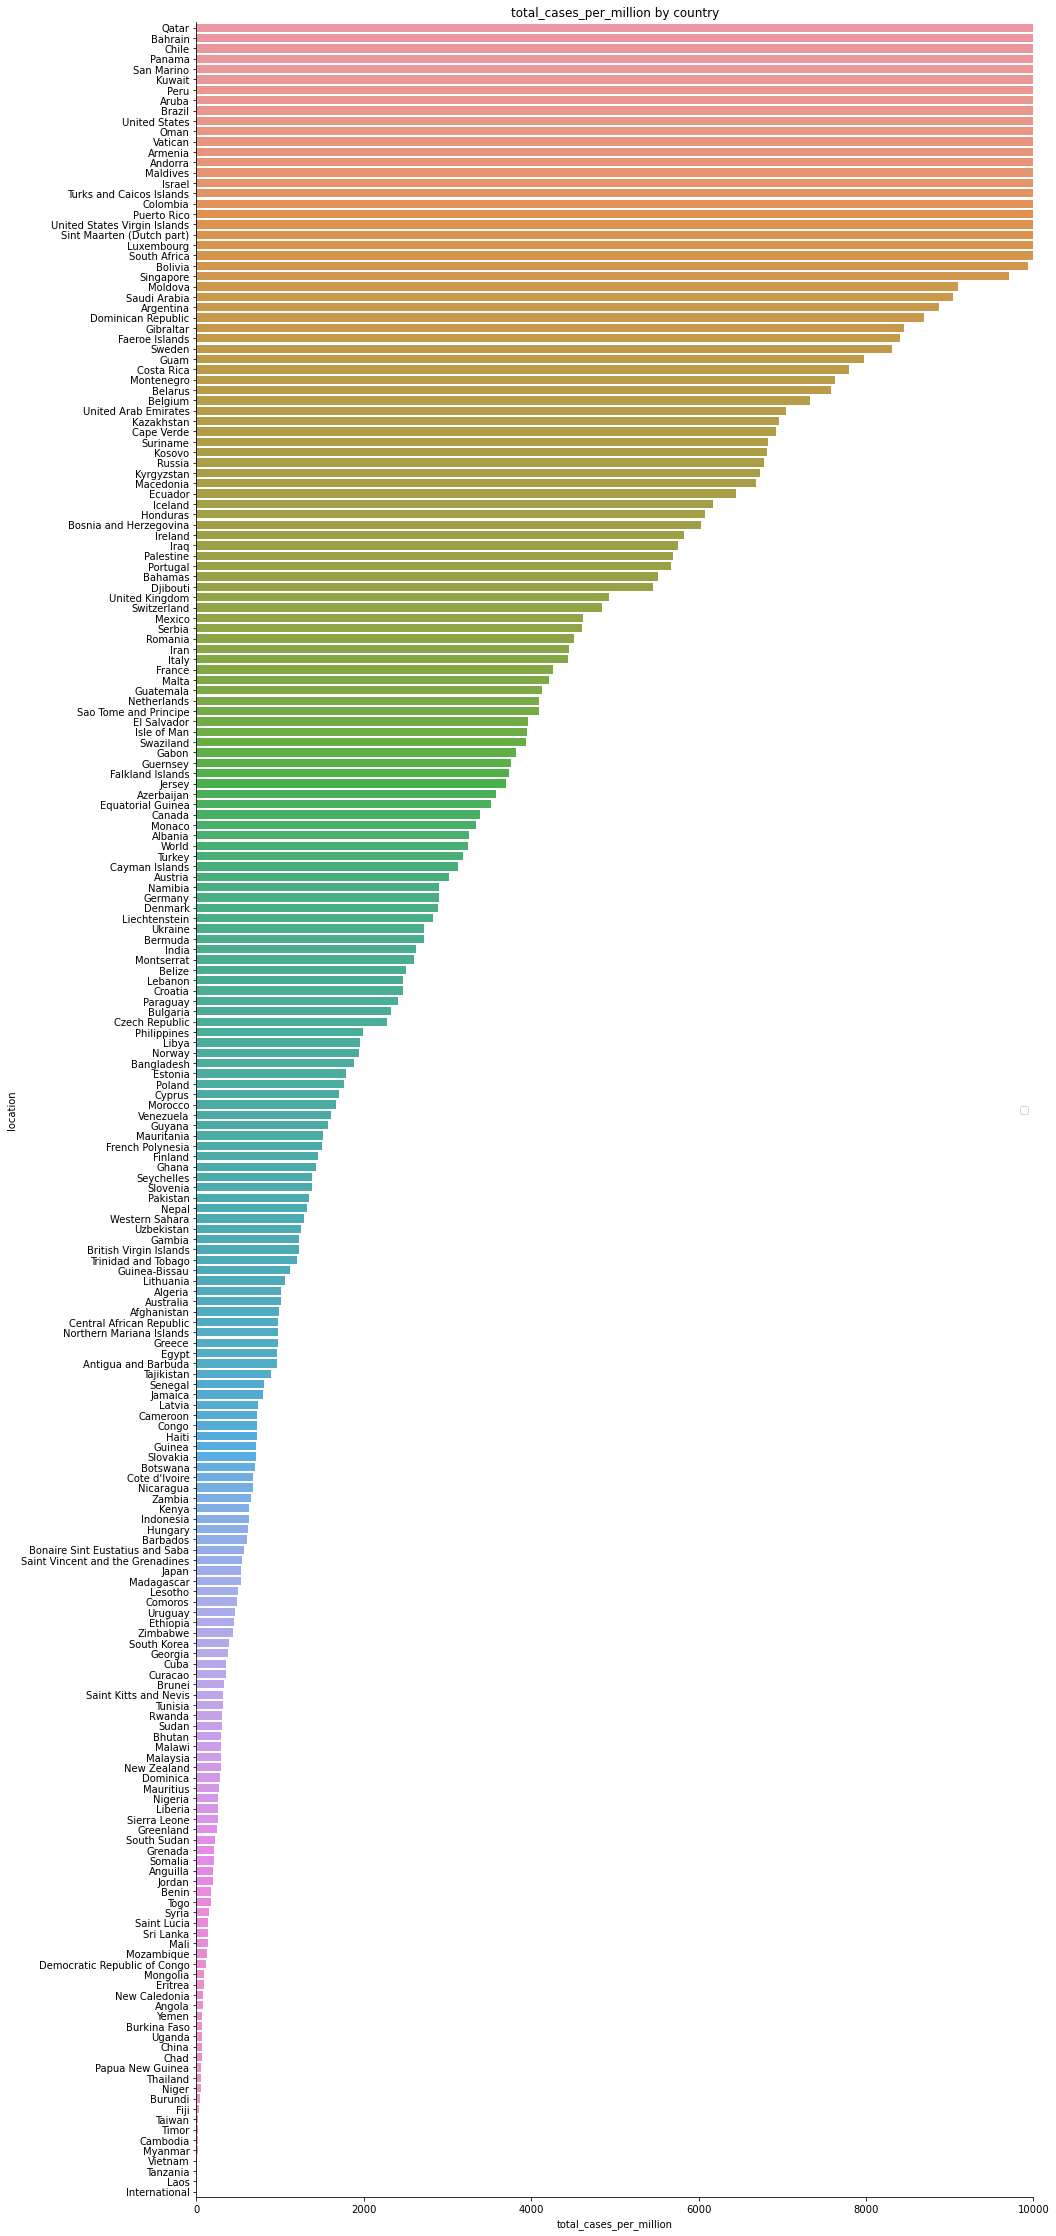

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


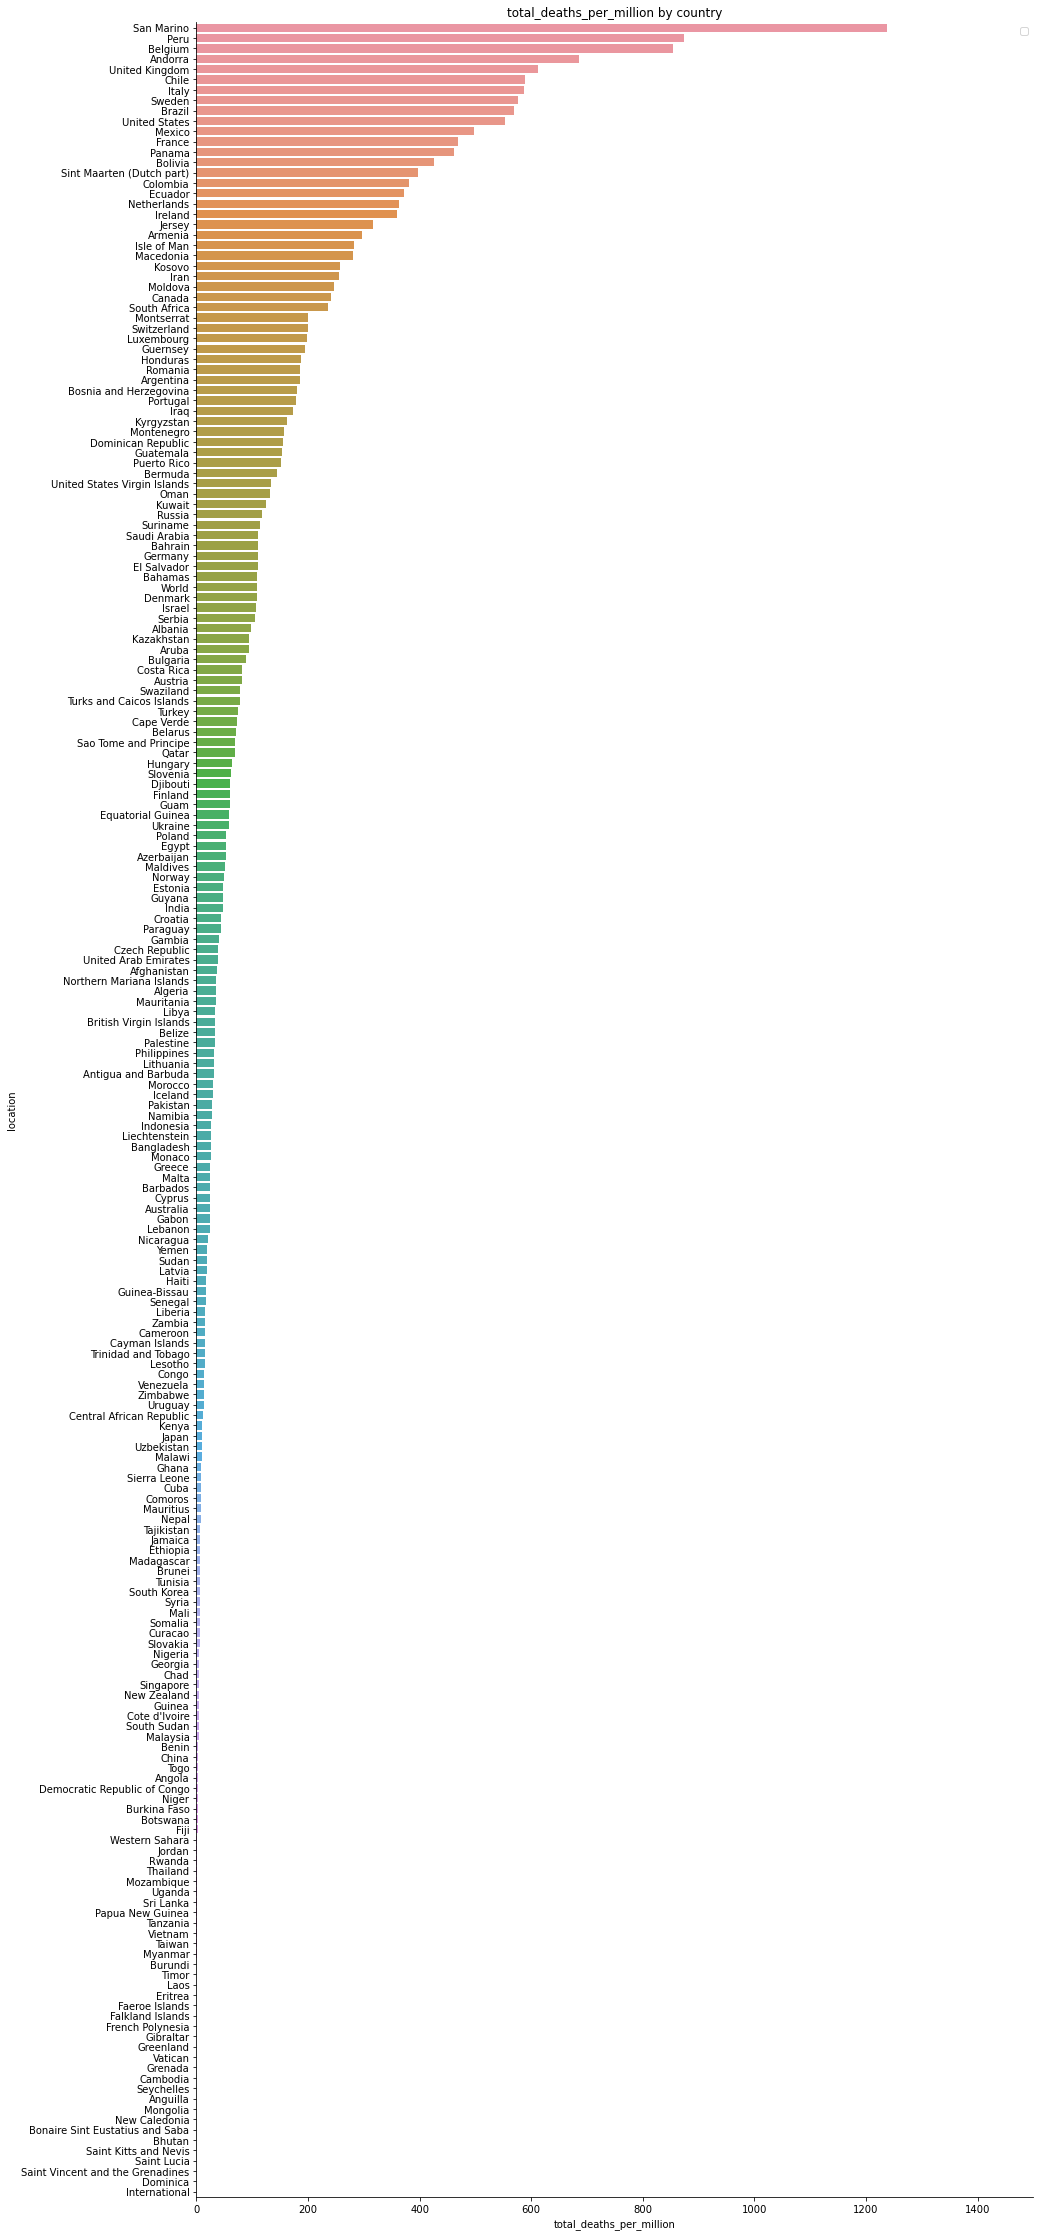

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

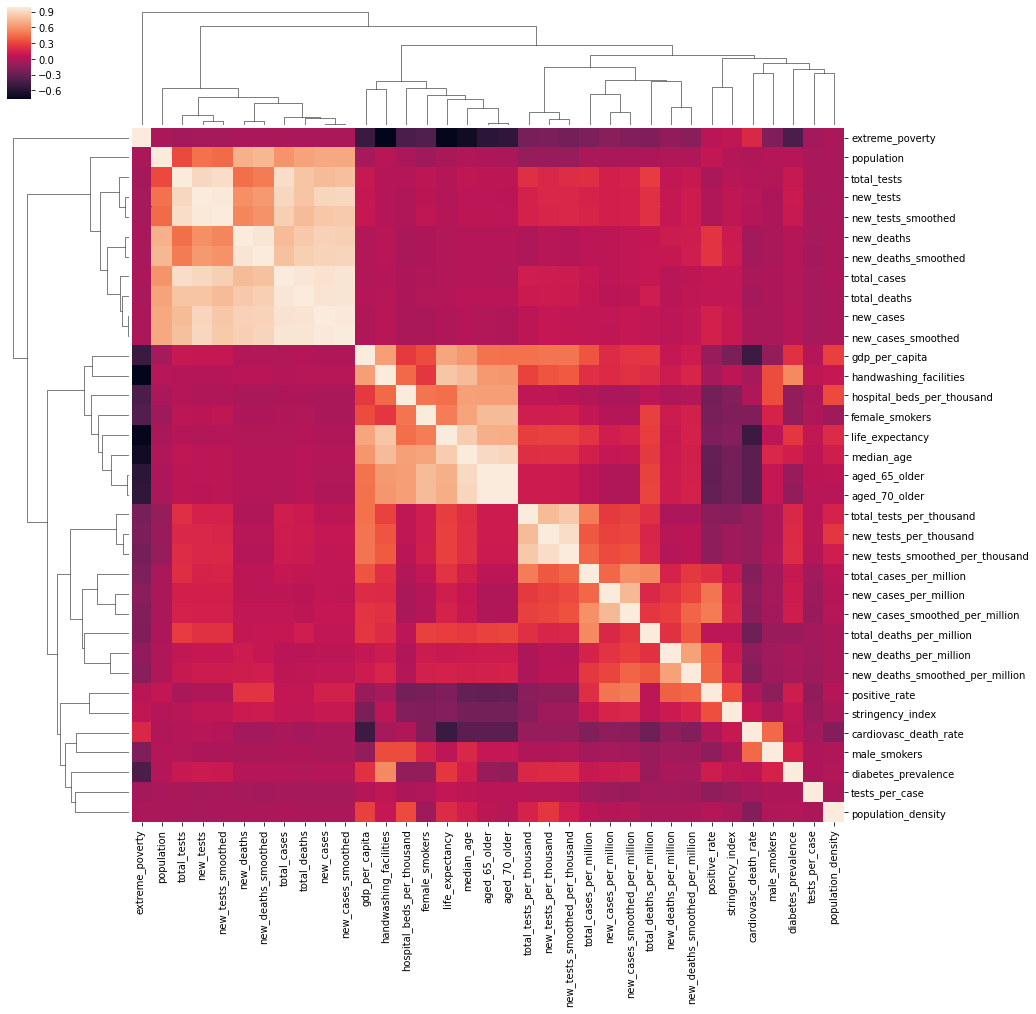

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.999364725380021 (+/- 0.0005365103698742219)
Coef :  [1.03749103e+00 9.13444987e-05 9.53112433e-05]
3 Last_days :  [[24761119 25029850 25251334]]
Today :  25251334
Prediction + :  524931
Tomorow :  25776265
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996457291443973 (+/- 6.744098613375723e-05)
Coef :  [0.04458515 0.46786245 0.49774324]
3 Last_days :  [[837466 843154 846841]]
Today :  846841
Prediction + :  9069
Tomorow :  855910
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9868029794283886 (+/- 0.011454975933960746)
Coef :  [-0.70839276  0.75249569  0.95813463]
3 Last_days :  [[267077 272530 277943]]
Today :  277943
Prediction + :  4437
Tomorow :  282380
                                     
--------- Total Death -----------------
                                     
R^2: 0.41351748148522666 (+/- 0.8204541110716806)
Coef :  [-0.7524757   0.7886717   0.96283837]
3 Last_days :  [[30596 30602 30606]]
Today :  30606
Prediction + :  26
Tomorow :  30632
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9165447910280945 (+/- 0.06318762901591087)
Coef :  [-0.32484785 -0.01949223  1.33860921]
3 Last_days :  [[89836 89863 89895]]
Today :  89895
Prediction + :  32
Tomorow :  89927
                                     
--------- Total Death -----------------
                                     
R^2: -196.00410759344223 (+/- 278.4595873504167)
Coef :  [-0.07700071  0.0124446   1.05646777]
3 Last_days :  [[4718 4721 4722]]
Today :  4722
Prediction + :  6
Tomorow :  4728
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8289985336760622 (+/- 0.24057165565647545)
Coef :  [-0.82833913  0.90037218  0.92726437]
3 Last_days :  [[265409 266853 268218]]
Today :  268218
Prediction + :  1290
Tomorow :  269508
                                     
--------- Total Death -----------------
                                     
R^2: 0.7613803333154058 (+/- 0.310110149755359)
Coef :  [-0.82921854  0.89987963  0.92845639]
3 Last_days :  [[35472 35473 35477]]
Today :  35477
Prediction + :  22
Tomorow :  35499
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6414259351846452 (+/- 0.49801667740218125)
Coef :  [-0.56647171  0.40619029  1.16113567]
3 Last_days :  [[439286 439286 439286]]
Today :  439286
Prediction + :  735
Tomorow :  440021
                                     
--------- Total Death -----------------
                                     
R^2: 0.1374571599752933 (+/- 1.0145233766549075)
Coef :  [-0.724667    0.62424224  1.09940064]
3 Last_days :  [[29011 29011 29011]]
Today :  29011
Prediction + :  8
Tomorow :  29019
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9870033175158212 (+/- 0.018048618055152673)
Coef :  [0.07962367 0.46441389 0.47214932]
3 Last_days :  [[5917439 5961582 5997163]]
Today :  5997163
Prediction + :  87825
Tomorow :  6084988
                                     
--------- Total Death -----------------
                                     
R^2: 0.8357958201617111 (+/- 0.23095972176451657)
Coef :  [-0.54081578  0.73205261  0.81132561]
3 Last_days :  [[181773 182779 183069]]
Today :  183069
Prediction + :  1278
Tomorow :  184347
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9161270350987731 (+/- 0.11724101525822701)
Coef :  [-0.73913219  0.85709837  0.88218809]
3 Last_days :  [[331644 332752 334467]]
Today :  334467
Prediction + :  1176
Tomorow :  335643
                                     
--------- Total Death -----------------
                                     
R^2: 0.37254175029090825 (+/- 0.8497943611871802)
Coef :  [-0.77241739  0.83198835  0.93983525]
3 Last_days :  [[41486 41498 41499]]
Today :  41499
Prediction + :  46
Tomorow :  41545
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9802475340221707 (+/- 0.025521291682142594)
Coef :  [-0.79882682  0.85817672  0.94027275]
3 Last_days :  [[240986 241771 242381]]
Today :  242381
Prediction + :  808
Tomorow :  243189
                                     
--------- Total Death -----------------
                                     
R^2: 0.3796368948921656 (+/- 0.8652587712308066)
Coef :  [-0.79194103  0.84134068  0.94992467]
3 Last_days :  [[9289 9295 9298]]
Today :  9298
Prediction + :  11
Tomorow :  9309
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -1.4719461370692468 (+/- 3.494628087063218)
Coef :  [0.22653106 0.39293137 0.39237027]
3 Last_days :  [[369911 371816 373570]]
Today :  373570
Prediction + :  4257
Tomorow :  377827
                                     
--------- Total Death -----------------
                                     
R^2: 0.945161400414683 (+/- 0.07688957397518723)
Coef :  [0.01136233 0.50385938 0.49700758]
3 Last_days :  [[21249 21359 21462]]
Today :  21462
Prediction + :  259
Tomorow :  21721
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.998292230862479 (+/- 0.0021254852526030204)
Coef :  [-0.73901632  0.84915733  0.8872164 ]
3 Last_days :  [[265515 267064 268546]]
Today :  268546
Prediction + :  1286
Tomorow :  269832
                                     
--------- Total Death -----------------
                                     
R^2: 0.9990618327078172 (+/- 0.0008112439448496607)
Coef :  [-0.81057259  0.89323298  0.91448636]
3 Last_days :  [[6245 6284 6326]]
Today :  6326
Prediction + :  31
Tomorow :  6357
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.45262003134936274 (+/- 0.7692909204575665)
Coef :  [-0.14247387  0.49946605  0.65929591]
3 Last_days :  [[3804803 3846153 3862311]]
Today :  3862311
Prediction + :  69305
Tomorow :  3931616
                                     
--------- Total Death -----------------
                                     
R^2: 0.4894383923446821 (+/- 0.7162600026253937)
Coef :  [-0.1142493   0.52067207  0.60617881]
3 Last_days :  [[119504 120462 120828]]
Today :  120828
Prediction + :  1743
Tomorow :  122571
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(25251334, 846841, 25776265, 855910),
 (277943, 30606, 282380, 30632),
 (268218, 35477, 269508, 35499),
 (439286, 29011, 440021, 29019),
 (5997163, 183069, 6084988, 184347),
 (89895, 4722, 89927, 4728),
 (334467, 41499, 335643, 41545),
 (242381, 9298, 243189, 9309),
 (373570, 21462, 377827, 21721),
 (268546, 6326, 269832, 6357),
 (3862311, 120828, 3931616, 122571)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-31,France,282380.0,0.0,30632.0,0.0,0.0,0.0
0,2020-08-31,China,89927.0,0.0,4728.0,0.0,0.0,0.0
0,2020-08-31,Italy,269508.0,0.0,35499.0,0.0,0.0,0.0
0,2020-08-31,Spain,440021.0,0.0,29019.0,0.0,0.0,0.0
0,2020-08-31,United States,6084988.0,0.0,184347.0,0.0,0.0,0.0
0,2020-08-31,World,25776265.0,0.0,855910.0,0.0,0.0,0.0
0,2020-08-31,United Kingdom,335643.0,0.0,41545.0,0.0,0.0,0.0
0,2020-08-31,Germany,243189.0,0.0,9309.0,0.0,0.0,0.0
0,2020-08-31,Iran,377827.0,0.0,21721.0,0.0,0.0,0.0
0,2020-08-31,Turkey,269832.0,0.0,6357.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")